## Imports

In [1]:
# %cd /home/liamroy/Documents/PHD/repos/RL_audio/notebooks

%cd /Users/liamroy/Documents/Studies/Monash_31194990/PHD/repos/RL_audio/notebooks

# %cd <add your path here and comment out the others>

/Users/liamroy/Documents/Studies/Monash_31194990/PHD/repos/RL_audio/notebooks


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget
# %matplotlib inline
# %matplotlib notebook

# Try to use this website to use the explode feature, so we can see internal blocks and space everything out
# https://terbium.io/2017/12/matplotlib-3d/ 

# Use this website to make your GIFs - generally 50 delay per frame is good
# https://ezgif.com/maker

## Initializations

In [3]:
def explode(data):
	shape_arr = np.array(data.shape)
	size = shape_arr[:3]*2 - 1
	exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
	exploded[::2, ::2, ::2] = data
	return exploded

def plot_3d_array(vox_array, save_str, title_str, plotter=True):

	# Create the figure
	fig = plt.figure(figsize=(14, 12))

	# Make it a 3D plot
	ax = fig.add_subplot(projection='3d')

	plt.title(f"{title_str}", size=20, y=0.95)

	
	# Set title, axes and ticks
	# ax.set_title(f"{title_str}", size=25)

	ax.set_xticks([]) # for minor ticks --> ax.set_xticks([], minor=True)
	ax.set_yticks([])
	ax.set_zticks([])

	ax.set_xlabel('100      -      140      -      180\n\nBeat Per Min', size=15)
	ax.set_ylabel('1   -  2   -  4\n\nBeat Per Loop', size=15)
	ax.set_zlabel('Neg   -   Neutral   -   Pos\n\nPitch Bend', size=15)


	# Set no grid and desired view angle
	ax.grid(False)
	ax.view_init(8, 285)


	# Define the colour map
	cmap = plt.get_cmap("RdYlGn")
	# norm= plt.Normalize(vox_array.min(), vox_array.max())
	norm= plt.Normalize(-10, 10)


	# Creates an array with a 1 at each location of the array where we want a voxel, then explode
	filled = np.ones_like(vox_array)
	filled = explode(filled)

	# Create a colourmap & explode
	colors = cmap(norm(vox_array), alpha=0.85)
	colors = explode(colors)
		
		
	# Plot the voxels 
	ax.voxels(filled, facecolors=colors, edgecolors='black', shade=False)


	# To get the colour bar (note scatter size is set to zero - workaround since no cbar w/ voxels)
	counter = range(3)
	x,y,z = np.meshgrid(counter, counter, counter)
	scatter_cube = ax.scatter(x,y,z, c=vox_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
	cbar = fig.colorbar(scatter_cube, shrink=0.45, orientation="vertical", aspect=8, pad=0.05) # Add a color bar
	cbar.minorticks_off()
	cbar.set_label('\naction value', rotation=90, size=15)


	# Save the fig
	plt.savefig(save_str, bbox_inches='tight', pad_inches=0.25)

	# Show the fig if plotter is not set to None
	if plotter:
		plt.show()

	
	if plotter == None:
		print(" Plots closed. ")
		matplotlib.pyplot.close()


# Matrix Plottter


## Mean of All User Final Matrices

For every condition there are 9 arrays --> 3 for each state:

- 3 for each state which take the mean of all the final Q-values of sect2X from all users

- 3 for each state which take the mean of all the final Q-values of sect2O from all users

- 3 for each state which take the mean of all the combined Q-values of sect2X and sect2O from all users

### Run this one to save heaps of photos which capture ALL users :3

Plottter saves all as .png files


In [ ]:
# Initializations ( NO SET REQUIRED ) 
param_disc = 3

user_ID_save_str = "all"		  

condition_list = ["all", "condA", "condB"]

all_list = [*range(3, 27)]
condA_list = [3, 4, 5, 6, 7, 8, 9, 10, 22, 23, 24, 25]
condB_list = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26] 


# For each of the three conditions:   
# "all"   = looking at all users
# "condA" = only looking at users from condA 
# "condB" = only looking at users from condB

for condition_str in condition_list:

	# For each of the 3 states
	for state_index in range(0, 3):

		# Reset user counter for sanity check & final calcs
		users_count = 0

		# Reset total array to zeros 
		total_array_sect2X = np.zeros((param_disc, param_disc, param_disc))
		total_array_sect2O = np.zeros((param_disc, param_disc, param_disc))
		total_array_combined = np.zeros((param_disc, param_disc, param_disc))

		
		# Select which users to consider based on condition
		if condition_str == "all":
			user_list = all_list
		
		elif condition_str == "condA":
			user_list = condA_list
			
		elif condition_str == "condB":
			user_list = condB_list
		else:
			print("ERROR at user_list")
			
			
			
		# Then for each user..
		for user_idx in user_list:

			users_count += 1

			user_ID_load_str = f"{user_idx:02}"
			# print("\nUSER: ", user_ID_load_str, "\n")

			user_array_sect2X = np.load("user_data/user_" + user_ID_load_str + "/arrays/" + user_ID_load_str + "_sect2X_final_st" + str(state_index) + ".npy")
			user_array_sect2O = np.load("user_data/user_" + user_ID_load_str + "/arrays/" + user_ID_load_str + "_sect2O_final_st" + str(state_index) + ".npy")

			total_array_sect2X += user_array_sect2X
			total_array_sect2O += user_array_sect2O
			total_array_combined += user_array_sect2X + user_array_sect2O



		# Sanity check of how many users considered in this batch (all, condA, or condB)	
		print(users_count, "users count:")
		

		# These arrays have just been summed, divide by number of users to get the mean
		total_array_sect2X = total_array_sect2X / users_count
		total_array_sect2O = total_array_sect2O / users_count
		total_array_combined = total_array_combined / (users_count*2.)


		# Calculate standard dev of each matrix:
		total_array_sect2X_std = np.std(total_array_sect2X)
		total_array_sect2O_std = np.std(total_array_sect2O)
		total_array_combined_std = np.std(total_array_combined)


		# Save the arrays:
		np.save("user_data/user_all/arrays/" + condition_str + "_sect2X_st" + str(state_index) + ".npy", total_array_sect2X)
		np.save("user_data/user_all/arrays/" + condition_str + "_sect2O_st" + str(state_index) + ".npy", total_array_sect2O)
		np.save("user_data/user_all/arrays/" + condition_str + "_combined_st" + str(state_index) + ".npy", total_array_combined)


		# Sanity check of shape / values of the arrays 
		print(f"{condition_str}_sect2X_st{str(state_index)}_array: ", total_array_sect2X.shape)
		print(f"{condition_str}_sect2O_st{str(state_index)}_array: ", total_array_sect2O.shape)
		print(f"{condition_str}_combined_st{str(state_index)}_array: ", total_array_combined.shape)
		print()


		# Create the save strings for the array plots
		sect2X_array_save_str = f"user_data/user_all/{condition_str}_st{state_index}_sect2X_plot.png"  # You can swap order: "_st{state_index" with "_sect2X_plot"
		sect2O_array_save_str = f"user_data/user_all/{condition_str}_st{state_index}_sect2O_plot.png"
		combined_array_save_str = f"user_data/user_all/{condition_str}_st{state_index}_combined_plot.png"


		# Create the title strings
		if state_index == 0:

			sect2X_title_str =   f"Mean Q-Values for Sect 2X Only\nState 0: Stuck  -  Condition: {condition_str}  -  Std: {total_array_sect2X_std:.3f}"
			sect2O_title_str =   f"Mean Q-Values for Sect 20 Only\nState 0: Stuck  -  Condition: {condition_str}  -  Std: {total_array_sect2O_std:.3f}"
			combined_title_str = f"Mean Q-Values Combining 2X and 2O\nState 0: Stuck  -  Condition: {condition_str}  -  Std: {total_array_combined_std:.3f}"

		elif state_index == 1:

			sect2X_title_str =   f"Mean Q-Values for Sect 2X Only\nState 1: Accomplished  -  Condition: {condition_str}  -  Std: {total_array_sect2X_std:.3f}"
			sect2O_title_str =   f"Mean Q-Values for Sect 20 Only\nState 1: Accomplished  -  Condition: {condition_str}  -  Std: {total_array_sect2O_std:.3f}"
			combined_title_str = f"Mean Q-Values Combining 2X and 2O\nState 1: Accomplished  -  Condition: {condition_str}  -  Std: {total_array_combined_std:.3f}"


		elif state_index == 2:

			sect2X_title_str =   f"Mean Q-Values for Sect 2X Only\nState 2: Progressing  -  Condition: {condition_str}  -  Std: {total_array_sect2X_std:.3f}"
			sect2O_title_str =   f"Mean Q-Values for Sect 20 Only\nState 2: Progressing  -  Condition: {condition_str}  -  Std: {total_array_sect2O_std:.3f}"
			combined_title_str = f"Mean Q-Values Combining 2X and 2O\nState 2: Progressing  -  Condition: {condition_str}  -  Std: {total_array_combined_std:.3f}"


		else:
			print("ERROR")


		plot_3d_array(total_array_sect2X, sect2X_array_save_str, sect2X_title_str, plotter=None)

		plot_3d_array(total_array_sect2O, sect2O_array_save_str, sect2O_title_str, plotter=None)

		plot_3d_array(total_array_combined, combined_array_save_str, combined_title_str, plotter=None)
		
		print()

## Single User Matrix Plottter

Plottter saves all as .png files

Run this one to save heaps of photos for a single user :3

In [5]:
# Initializations ( PLEASE SET WHICH USER )


user_ID_str = "15"


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
max_steps_to_plot = 100
param_disc = 3

section_str_list = ["2X", "2O"]

step_nums = []

for i in range(0, max_steps_to_plot):	# remember this is non inclusive of the last number 
	step_nums.append("step" + f"{i:02}")

step_nums.append("final")		   
		  
    
# For both sect2X and sect2O
for section_str in section_str_list:

    print(f"\nSection: sect{section_str}")
    
    counter = 0

    for step_num in step_nums:

        print(step_num)

        if step_num == "step00":
            if section_str == "2O":	   
                st0_array = np.load("user_data/user_" + user_ID_str + "/arrays/pilotset_st0.npy")
                st1_array = np.load("user_data/user_" + user_ID_str + "/arrays/pilotset_st1.npy")
                st2_array = np.load("user_data/user_" + user_ID_str + "/arrays/pilotset_st2.npy")

            elif section_str == "2X": # dont start with the initialized Q-table
                st0_array = np.ones((param_disc, param_disc, param_disc)) * 10.0
                st1_array = np.ones((param_disc, param_disc, param_disc)) * 10.0
                st2_array = np.ones((param_disc, param_disc, param_disc)) * 10.0

            else:
                print("ERROR at arrays")
                
            st0_array_std = np.std(st0_array)
            st1_array_std = np.std(st1_array)
            st2_array_std = np.std(st2_array)

            st0_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st0_plot{counter:02}_{step_num}.png" 
            st1_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st1_plot{counter:02}_{step_num}.png" 
            st2_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st2_plot{counter:02}_{step_num}.png" 

            step_str = step_num # ex: could be "step03" or "final"

            st0_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 0: Stuck  -  Std: {st0_array_std:.3f}" 
            st1_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 1: Accomplished  -  Std: {st1_array_std:.3f}" 
            st2_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 2: Progressing  -  Std: {st2_array_std:.3f}" 

            print(f"running plotter @ {step_num}")
            plot_3d_array(st0_array, st0_array_save_str, st0_title_str, plotter=None)
            plot_3d_array(st1_array, st1_array_save_str, st1_title_str, plotter=None)
            plot_3d_array(st2_array, st2_array_save_str, st2_title_str, plotter=None)

            counter += 1
            continue 


        step_str = step_num # ex: could be "step03" or "final"
        load_file = user_ID_str + "_sect" + section_str + "_" + step_str

        st0_array_path_str = "user_data/user_" + user_ID_str + "/arrays/" + load_file + "_st0.npy"
        st1_array_path_str = "user_data/user_" + user_ID_str + "/arrays/" + load_file + "_st1.npy"
        st2_array_path_str = "user_data/user_" + user_ID_str + "/arrays/" + load_file + "_st2.npy"

        try:

            st0_array = np.load(st0_array_path_str)
            st1_array = np.load(st1_array_path_str)
            st2_array = np.load(st2_array_path_str)

            st0_array_std = np.std(st0_array)
            st1_array_std = np.std(st1_array)
            st2_array_std = np.std(st2_array)

            st0_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st0_plot{counter:02}_{step_num}.png" 
            st1_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st1_plot{counter:02}_{step_num}.png" 
            st2_array_save_str = "user_data/user_" + user_ID_str + "/sect" + section_str + f"_st2_plot{counter:02}_{step_num}.png" 

            st0_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 0: Stuck  -  Std: {st0_array_std:.3f}" 
            st1_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 1: Accomplished  -  Std: {st1_array_std:.3f}" 
            st2_title_str = f"User {user_ID_str} Q-values  -  Sect{section_str} @ {step_str}\nState 2: Progressing  -  Std: {st2_array_std:.3f}" 

            print(f"running plotter @ {step_num}")
            plot_3d_array(st0_array, st0_array_save_str, st0_title_str, plotter=None)
            plot_3d_array(st1_array, st1_array_save_str, st1_title_str, plotter=None)
            plot_3d_array(st2_array, st2_array_save_str, st2_title_str, plotter=None)

            counter += 1

        except FileNotFoundError:
            print(f"No file: {step_num}")
            continue


Section: sect2X
step00
running plotter @ step00
 Plots closed. 
 Plots closed. 
 Plots closed. 
step01
running plotter @ step01
 Plots closed. 
 Plots closed. 
 Plots closed. 
step02
running plotter @ step02
 Plots closed. 
 Plots closed. 
 Plots closed. 
step03
running plotter @ step03
 Plots closed. 
 Plots closed. 
 Plots closed. 
step04
running plotter @ step04
 Plots closed. 
 Plots closed. 
 Plots closed. 
step05
running plotter @ step05
 Plots closed. 
 Plots closed. 
 Plots closed. 
step06
running plotter @ step06
 Plots closed. 
 Plots closed. 
 Plots closed. 
step07
running plotter @ step07
 Plots closed. 
 Plots closed. 
 Plots closed. 
step08
running plotter @ step08
 Plots closed. 
 Plots closed. 
 Plots closed. 
step09
running plotter @ step09
 Plots closed. 
 Plots closed. 
 Plots closed. 
step10
running plotter @ step10
 Plots closed. 
 Plots closed. 
 Plots closed. 
step11
running plotter @ step11
 Plots closed. 
 Plots closed. 
 Plots closed. 
step12
running plotter 

## Single Matrix Plotter for Conf Report

[[[1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 1. 0. 1.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 1. 0. 1.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 0. 1. 0. 1.]]]


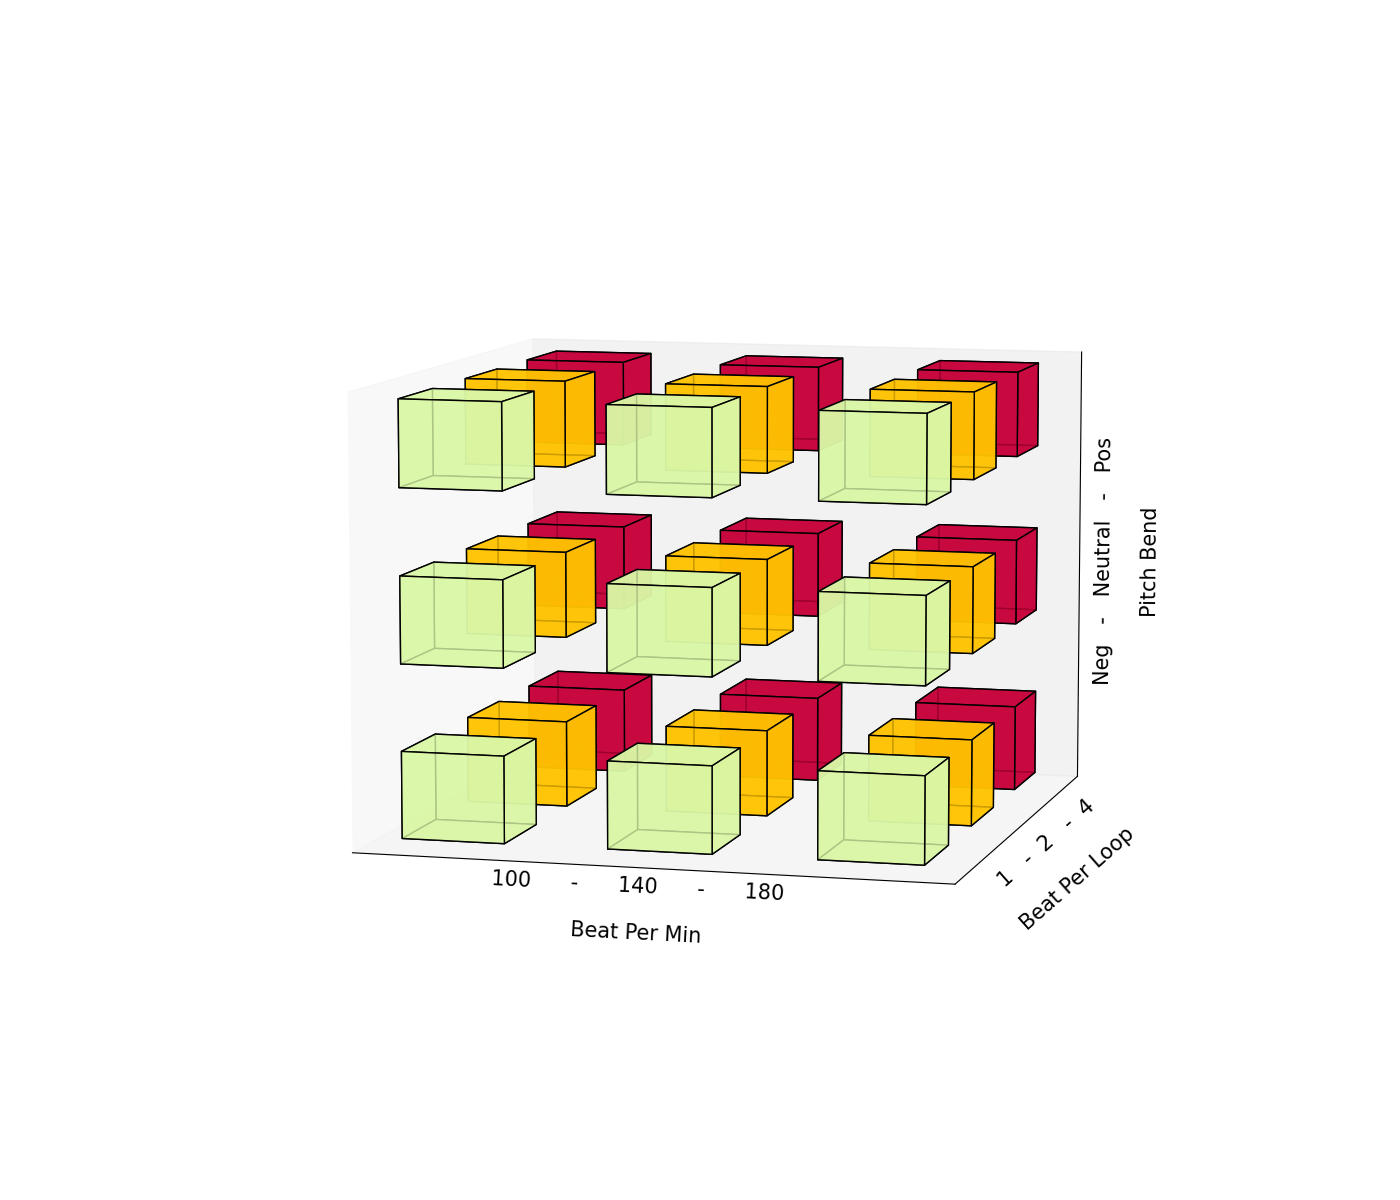

In [64]:

single_array = np.ones((3,3,3))

single_title_str = " "

single_save_str = "images/blank_vox_plot.png"

fig = plt.figure(figsize=(14, 12))

# Make it a 3D plot
ax = fig.add_subplot(projection='3d')

plt.title(f"{single_title_str}", size=20, y=0.95)


# Set title, axes and ticks
# ax.set_title(f"{title_str}", size=25)

ax.set_xticks([]) # for minor ticks --> ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel('100      -      140      -      180\n\nBeat Per Min', size=15)
ax.set_ylabel('1   -  2   -  4\n\nBeat Per Loop', size=15)
ax.set_zlabel('Neg   -   Neutral   -   Pos\n\nPitch Bend', size=15)


# Set no grid and desired view angle
ax.grid(False)
ax.view_init(8, 285)


# Define the colour map
cmap = plt.get_cmap("RdYlGn")
# norm= plt.Normalize(single_array.min(), single_array.max())
norm= plt.Normalize(-10, 10)


# Creates an array with a 1 at each location of the array where we want a voxel, then explode
filled = np.ones_like(single_array)
filled = explode(filled)

colors = np.empty((5, 5, 5))

print(colors)


# Create a colourmap & explode
# colors = cmap(norm(single_array), alpha=0.85)
# colors = explode(colors)

# n_voxels = np.zeros((5, 5, 5), dtype=bool)
# n_voxels[:, :, :] = True
# n_voxels[:, 2, :] = False
# facecolors = np.where(n_voxels, "#FADF8299", "#FAA78299")

facecolors[:, 0, :] = "#DAF7A6CC"

facecolors[:, 2, :] = "#FFC300CC"

facecolors[:, 4, :] = "#C70039CC"


# filled = np.ones(n_voxels.shape)



# "#FADF8299"
# "#FAA78299"

# Plot the voxels 
ax.voxels(filled, facecolors=facecolors, edgecolors='black', shade=False)


# To get the colour bar (note scatter size is set to zero - workaround since no cbar w/ voxels)
# counter = range(3)
# x,y,z = np.meshgrid(counter, counter, counter)
# scatter_cube = ax.scatter(x,y,z, c=vox_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
# cbar = fig.colorbar(scatter_cube, shrink=0.45, orientation="vertical", aspect=8, pad=0.05) # Add a color bar
# cbar.minorticks_off()
# cbar.set_label('\naction value', rotation=90, size=15)


# Save the fig
plt.savefig(single_save_str, bbox_inches='tight', pad_inches=0.25)

# Show the fig if plotter is not set to None
plt.show()

In [27]:
print(" Plots closed. ")
matplotlib.pyplot.close()

 Plots closed. 


## ARCHIVE

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def explode(data):
	shape_arr = np.array(data.shape)
	size = shape_arr[:3]*2 - 1
	exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
	exploded[::2, ::2, ::2] = data
	return exploded

def plot_3d_array(vox_array):
	
# Create the figure
fig = plt.figure(figsize=(12, 10))

# Make it a 3D plot
ax = fig.add_subplot(projection='3d')

# Set title, axes and ticks
ax.set_title("STATE 2 - STUCK", size=25)

ax.set_xticks([]) # for minor ticks --> ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel('100	  -	  140	  -	  180\n\nBeat Per Min', size=15)
ax.set_ylabel('1   -  2   -  4\n\nBeat Per Loop', size=15)
ax.set_zlabel('Neg   -   Neutral   -   Pos\n\nPitch Bend', size=15)


# Set no grid and desired view angle
ax.grid(False)
ax.view_init(8, 285)


# Define the colour map
cmap = plt.get_cmap("RdYlGn")
norm= plt.Normalize(st0_array.min(), st0_array.max())


# Creates an array with a 1 at each location of the array where we want a voxel, then explode
filled = np.ones_like(st0_array)
filled = explode(filled)

# Create a colourmap & explode
colors = cmap(norm(st0_array), alpha=0.85)
colors = explode(colors)


# Plot the voxels 
ax.voxels(filled, facecolors=colors, edgecolors='black', shade=False)


# To get the colour bar (note scatter size is set to zero - workaround since no cbar w/ voxels)
counter = range(3)
x,y,z = np.meshgrid(counter, counter, counter)
scatter_cube = ax.scatter(x,y,z, c=st2_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
cbar = fig.colorbar(scatter_cube, shrink=0.45, orientation="vertical", aspect=8, pad=0.15) # Add a color bar
cbar.minorticks_off()


# Save the fig
plt.savefig("test.png", bbox_inches='tight', pad_inches=0.5)

# Show the fig
plt.show()

In [ ]:
# Another attempt at VOXELS

from mpl_toolkits.mplot3d import Axes3D

def explode(data, splitter=2):
	shape_arr = np.array(data.shape)
	size = shape_arr[:3]*splitter - 1
	exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
	exploded[::splitter, ::splitter, ::splitter] = data
	return exploded


def expand_coordinates(indices):
	x, y, z = indices
	x[1::2, :, :] += 1
	y[:, 1::2, :] += 1
	z[:, :, 1::2] += 1
	return x, y, z


colors = cmap(norm(st2_array), alpha=0.55)
colors = explode(colors)


# Creates an array with a 1 at each location of the array where we want a voxel
filled = np.ones_like(st2_array)
filled = explode(filled)


x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d') #change subplot for gca
ax.set_title("STATE 2 - STUCK", size=15)

ax.grid(False)

angle = 320
ax.view_init(30, angle)


ax.set_xticks([])
# for minor ticks
# ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel('100	-	140	-	180\n\nBeat Per Min', size=15)
ax.set_ylabel('1	  -	2	  -	4\n\nBeat Per Loop', size=15)
ax.set_zlabel('Neg   -   Neutral   -   Pos\n\nPitch Bend', size=15)


ax.voxels(x, y, z, filled, facecolors=colors, edgecolors='grey', shade=False)

# To get the colour bar (note scatter size is set to zero
counter = range(3)
x,y,z = np.meshgrid(counter, counter, counter)
scatter_cube = ax.scatter(x,y,z, c=st2_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
cbar = fig.colorbar(scatter_cube, shrink=0.75, orientation="vertical", aspect=15, pad=0.15) # Add a color bar
cbar.minorticks_on()


plt.show()

In [ ]:
# STATE 0

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.set_title("STATE 0 - PROGRESSING", size=15)

cmap = plt.get_cmap("RdYlGn")
norm= plt.Normalize(st0_array.min(), st0_array.max())

filled = np.ones_like(st0_array)

# Print the voxel cube
cube = ax.voxels(filled, facecolors=cmap(norm(st0_array)), edgecolor="white", alpha=0.75)

# To get the colour bar (note scatter size is set to zero
counter = range(3)
x,y,z = np.meshgrid(counter, counter, counter)
scatter_cube = ax.scatter(x,y,z, c=st0_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
cbar = fig.colorbar(scatter_cube, shrink=0.75, orientation="horizontal", aspect=15, pad=0.05) # Add a color bar
cbar.minorticks_on()

ax.set_xticks([])
# for minor ticks
# ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_zticks([])

plt.tick_params(
	axis='x',		  # changes apply to the x-axis
	which='both',	  # both major and minor ticks are affected
	bottom=False,	  # ticks along the bottom edge are off
	top=False,		 # ticks along the top edge are off
	labelbottom=True)

ax.set_xlabel('0	-	1	 -	2\nBeat Per Min', size=15)
ax.set_ylabel('0	-	1	 -	2\nBeat Per Loop', size=15)
ax.set_zlabel('0	-	1	 -	2\nPitch Bend', size=15)

plt.show()

In [ ]:
# STATE 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.set_title("STATE 1 - SUCCESSFUL", size=15)

cmap = plt.get_cmap("RdYlGn")
norm= plt.Normalize(st1_array.min(), st1_array.max())

filled = np.ones_like(st1_array)

# Print the voxel cube
cube = ax.voxels(filled, facecolors=cmap(norm(st1_array)), edgecolor="white", alpha=0.75)

# To get the colour bar (note scatter size is set to zero
counter = range(3)
x,y,z = np.meshgrid(counter, counter, counter)
scatter_cube = ax.scatter(x,y,z, c=st1_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
cbar = fig.colorbar(scatter_cube, shrink=0.75, orientation="horizontal", aspect=15, pad=0.05) # Add a color bar
cbar.minorticks_on()

ax.set_xticks([])
# for minor ticks
# ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_zticks([])

plt.tick_params(
	axis='x',		  # changes apply to the x-axis
	which='both',	  # both major and minor ticks are affected
	bottom=False,	  # ticks along the bottom edge are off
	top=False,		 # ticks along the top edge are off
	labelbottom=True)

ax.set_xlabel('0	-	1	 -	2\nBeat Per Min', size=15)
ax.set_ylabel('0	-	1	 -	2\nBeat Per Loop', size=15)
ax.set_zlabel('0	-	1	 -	2\nPitch Bend', size=15)

plt.show()

In [ ]:
# STATE 2

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.set_title("STATE 2 - STUCK", size=15)

cmap = plt.get_cmap("RdYlGn")
norm= plt.Normalize(st2_array.min(), st2_array.max())

# Creates an array with a 1 at each location of the array where we want a voxel
filled = np.ones_like(st2_array)

# Print the voxel cube
cube = ax.voxels(filled, facecolors=cmap(norm(st2_array)), edgecolor="white", alpha=0.75)

# To get the colour bar (note scatter size is set to zero
counter = range(3)
x,y,z = np.meshgrid(counter, counter, counter)
scatter_cube = ax.scatter(x,y,z, c=st2_array.flat, cmap=plt.get_cmap("RdYlGn"), s=0, alpha=0.8, linewidths=2, edgecolors="black", vmin=-10, vmax=10)
cbar = fig.colorbar(scatter_cube, shrink=0.75, orientation="horizontal", aspect=15, pad=0.05) # Add a color bar
cbar.minorticks_on()

ax.set_xticks([])
# for minor ticks
# ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_zticks([])

plt.tick_params(
	axis='x',		  # changes apply to the x-axis
	which='both',	  # both major and minor ticks are affected
	bottom=False,	  # ticks along the bottom edge are off
	top=False,		 # ticks along the top edge are off
	labelbottom=True)

ax.set_xlabel('0	-	1	 -	2\nBeat Per Min', size=15)
ax.set_ylabel('0	-	1	 -	2\nBeat Per Loop', size=15)
ax.set_zlabel('0	-	1	 -	2\nPitch Bend', size=15)

plt.show()

In [ ]:
matplotlib.pyplot.close()